In [38]:
import os
import numpy as np
from glob import glob
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader,   Dataset
import  matplotlib.pyplot as plt
import cv2
import torchvision.transforms as T
from scipy.io import loadmat
from torchvision import transforms
from PIL import Image


# Model Build

In [ ]:
import torch
import torch.nn as nn

class UNet(nn.Module):
    def __init__(self, num_classes=1):
        super(UNet, self).__init__()
        def Crowd(in_channels, out_channels):
            return nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
                nn.BatchNorm2d(out_channels),
                nn.ReLU(inplace=True),
                nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
                nn.BatchNorm2d(out_channels),
                nn.ReLU(inplace=True),
                nn.Dropout2d(0.3)  
            )
        
        self.enc1 = Crowd(3, 64)
        self.enc2 = Crowd(64, 128)
        self.enc3 = Crowd(128, 256)
        self.enc4 = Crowd(256, 512)
        self.enc5 = Crowd(512, 1024)

        self.pool = nn.MaxPool2d(2)  
        
        self.bottleneck = Crowd(1024, 2048)

        self.upconv5 = nn.ConvTranspose2d(2048, 1024, kernel_size=2, stride=2)
        self.dec5 = Crowd(2048, 1024)
        
        self.upconv4 = nn.ConvTranspose2d(1024, 512, kernel_size=2, stride=2)
        self.dec4 = Crowd(1024, 512)
        
        self.upconv3 = nn.ConvTranspose2d(512, 256, kernel_size=2, stride=2)
        self.dec3 = Crowd(512, 256)
        
        self.upconv2 = nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2)
        self.dec2 = Crowd(256, 128)
        
        self.upconv1 = nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2)
        self.dec1 = Crowd(128, 64)

        self.final = nn.Conv2d(64, num_classes, kernel_size=1)

    def forward(self, x):
        e1 = self.enc1(x)
        e2 = self.enc2(self.pool(e1))
        e3 = self.enc3(self.pool(e2))
        e4 = self.enc4(self.pool(e3))
        e5 = self.enc5(self.pool(e4))

        b = self.bottleneck(self.pool(e5))

        d5 = self.upconv5(b)
        d5 = self.dec5(torch.cat([d5, e5], dim=1))
        
        d4 = self.upconv4(d5)
        d4 = self.dec4(torch.cat([d4, e4], dim=1))
        
        d3 = self.upconv3(d4)
        d3 = self.dec3(torch.cat([d3, e3], dim=1))
        
        d2 = self.upconv2(d3)
        d2 = self.dec2(torch.cat([d2, e2], dim=1))
        
        d1 = self.upconv1(d2)
        d1 = self.dec1(torch.cat([d1, e1], dim=1))

        return self.final(d1)



In [40]:
device = "cuda"
model = UNet(num_classes=1)  
model = model.to(device)

# Before its completed

# Dataset part

In [41]:
mat = loadmat("ShanghaiTech/part_B_final/train_data/ground_truth/GT_IMG_10.mat")
print(mat.keys())
print(mat['image_info'])

dict_keys(['__header__', '__version__', '__globals__', 'image_info'])
[[array([[(array([[ 1.30650369e+02,  3.53611408e+02],
                 [ 8.46855106e+00,  2.43897122e+02],
                 [ 1.24166030e+01,  1.94338681e+02],
                 [ 6.18283677e+00,  1.41351668e+02],
                 [ 9.29971989e+00,  1.28884135e+02],
                 [ 2.92477718e+01,  1.22026993e+02],
                 [ 8.03646550e+01,  1.08936084e+02],
                 [ 1.04052967e+02,  9.14815381e+01],
                 [ 1.17767252e+02,  8.96114082e+01],
                 [ 1.35221798e+02,  1.45715304e+02],
                 [ 1.30858161e+02,  1.67533486e+02],
                 [ 1.27117902e+02,  1.95585434e+02],
                 [ 5.85464731e+01,  1.76884135e+02],
                 [ 1.65767252e+02,  1.36988032e+02],
                 [ 1.44572447e+02,  5.40789407e+01],
                 [ 1.19637382e+02,  3.66243952e+01],
                 [ 9.34555640e+01,  1.23127069e+01],
                 [ 9.4078940

# Dataloader

In [43]:
from torch.utils.data import Dataset
import os
import cv2
import numpy as np
from PIL import Image
from scipy.io import loadmat
import torch

class ShanghaiTechCrowdCountingDataset(Dataset):
    def __init__(self, image_dir, gt_dir, transform=None, img_size=(256, 256)):
        self.image_dir = image_dir
        self.gt_dir = gt_dir
        self.transform = transform
        self.img_size = img_size
        self.image_files = sorted(os.listdir(image_dir))
        self.gt_files = sorted(os.listdir(gt_dir))

    def __len__(self):
        return len(self.image_files)

    def generate_density_map(self, img, coordinates):
        density_map = np.zeros(img.shape[:2], dtype=np.float32)
        kernel_size = 15
        sigma = 4.0

        for coord in coordinates:
            x, y = int(coord[0]), int(coord[1])
            gaussian_kernel = self.create_gaussian_kernel(kernel_size, sigma)

            x_min = max(x - kernel_size // 2, 0)
            y_min = max(y - kernel_size // 2, 0)
            x_max = min(x + kernel_size // 2, img.shape[1])
            y_max = min(y + kernel_size // 2, img.shape[0])

            if x_max > x_min and y_max > y_min:
                cropped = gaussian_kernel[:y_max - y_min, :x_max - x_min]
                cropped /= np.sum(cropped)
                density_map[y_min:y_max, x_min:x_max] += cropped

        return density_map

    def create_gaussian_kernel(self, kernel_size, sigma):
        ax = np.linspace(-(kernel_size // 2), kernel_size // 2, kernel_size)
        xx, yy = np.meshgrid(ax, ax)
        kernel = np.exp(-(xx**2 + yy**2) / (2 * sigma**2))
        kernel /= np.sum(kernel)
        return kernel

    def __getitem__(self, idx):
        image_path = os.path.join(self.image_dir, self.image_files[idx])
        gt_path = os.path.join(self.gt_dir, self.gt_files[idx])

        image = cv2.imread(image_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        mat_data = loadmat(gt_path)
        coordinates = mat_data['image_info'][0, 0]['location'][0, 0]

        density_map = self.generate_density_map(image, coordinates)

        image = cv2.resize(image, self.img_size)
        orig_count = np.sum(density_map)
        density_map = cv2.resize(density_map, self.img_size)
        density_map *= (orig_count / (np.sum(density_map) + 1e-6))

        image = Image.fromarray(image)

        if self.transform:
            image = self.transform(image)

        density_map = torch.tensor(density_map, dtype=torch.float32).unsqueeze(0)

        return image, density_map


# Dataset Load

In [ ]:
image_dir = "ShanghaiTech/part_B_final/train_data/images"
gt_dir = "ShanghaiTech/part_B_final/train_data/ground_truth"

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  
])


train_dataset = ShanghaiTechCrowdCountingDataset(image_dir=image_dir, gt_dir=gt_dir, transform=transform)

batch_size = 4
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=4)

for images, density_maps in train_loader:
    print("Batch of images shape:", images.shape)  
    print("Batch of density maps shape:", density_maps.shape)  
    break  


Batch of images shape: torch.Size([4, 3, 256, 256])
Batch of density maps shape: torch.Size([4, 1, 256, 256])


In [45]:
image_dir = "ShanghaiTech/part_B_final/test_data/images"
gt_dir = "ShanghaiTech/part_B_final/test_data/ground_truth"
val_dataset = ShanghaiTechCrowdCountingDataset(image_dir=image_dir, gt_dir=gt_dir, transform=transform)

batch_size = 4
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True, num_workers=4)

for images, density_maps in val_loader:
    print("Batch of images shape:", images.shape)  
    print("Batch of density maps shape:", density_maps.shape)  
    break  


Batch of images shape: torch.Size([4, 3, 256, 256])
Batch of density maps shape: torch.Size([4, 1, 256, 256])


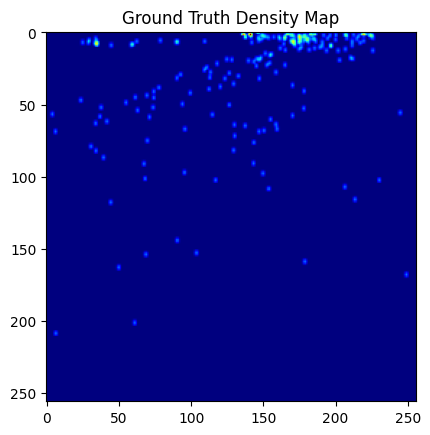

In [46]:
sample_img, sample_gt_map = next(iter(val_loader))  
sample_gt_map = sample_gt_map[3].cpu().numpy().squeeze()

plt.imshow(sample_gt_map, cmap='jet')
plt.title(f"Ground Truth Density Map")
# plt.colorbar()
plt.show()


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.64].


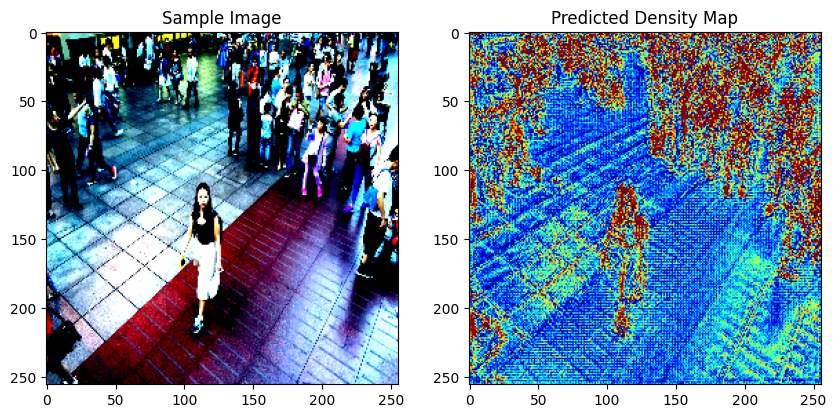

In [47]:
import matplotlib.pyplot as plt

def plot_density_map(pred_density_map, sample_img, sample_gt_map):
    plt.figure(figsize=(10, 5))

    # Display the sample image
    plt.subplot(1, 2, 1)
    plt.imshow(sample_img.permute(1, 2, 0).cpu().numpy())  # Image is CxHxW, need to permute to HxWxC
    plt.title("Sample Image")
    
    # Ensure that the predicted density map has the correct shape
    if pred_density_map.ndim == 3:  # If it has the shape (1, H, W), squeeze the first dimension
        pred_density_map = pred_density_map.squeeze(0)  # (H, W)
    elif pred_density_map.ndim == 4:  # If it has the shape (batch_size, 1, H, W), we can select the first item
        pred_density_map = pred_density_map[0, 0, :, :]  # Select the first sample and remove the channel dimension

    # Plot the predicted density map
    plt.subplot(1, 2, 2)
    plt.imshow(pred_density_map, cmap='jet')  # Show the predicted density map with jet colormap
    # plt.colorbar()
    plt.title("Predicted Density Map")
    
    plt.show()


# Visualize during validation
sample_img, sample_gt_map = next(iter(val_loader))
sample_img, sample_gt_map = sample_img.to(device), sample_gt_map.to(device)

# Get prediction
pred_density_map = model(sample_img).cpu().detach().numpy()
pred_density_map = np.maximum(pred_density_map, 0)
pred_density_map = np.clip(pred_density_map, 0, 1)

# Plot
plot_density_map(pred_density_map, sample_img[0], sample_gt_map[0])


In [48]:
# criterion = nn.BCEWithLogitsLoss()
criterion = nn.MSELoss()  # Using MSELoss for density map regression
# optimizer = optim.Adam(model.parameters(), lr=1e-5)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4, weight_decay=1e-5)

In [49]:
def count_people(density_map):
    count = float(np.sum(density_map))  # density_map should be a float32 array
    print(f"Counted {count} people in the density map.")
    return count

In [50]:
def evaluate_model(model, val_loader, device):
    model.eval()  
    running_loss = 0.0
    with torch.no_grad():  
        for imgs, gt_maps in val_loader:
            imgs, gt_maps = imgs.to(device), gt_maps.to(device)
            
            outputs = model(imgs)
            # outputs = torch.sigmoid(outputs)
            # outputs = torch.clamp(outputs, min=0, max=1)  

            
            loss = criterion(outputs, gt_maps)
            running_loss += loss.item()
    
    avg_loss = running_loss / len(val_loader)
    return avg_loss

In [51]:
def plot(gt_count, pred_density_map, pred_count, image, sam_gt_map):
    plt.figure(figsize=(15, 5))

    plt.subplot(1, 3, 1)
    plt.imshow(image.cpu().numpy().transpose(1, 2, 0))
    plt.title("Input Image")
    plt.axis('off')

    plt.subplot(1, 3, 2)
    plt.imshow(sam_gt_map.cpu().numpy().squeeze(), cmap='jet')
    plt.title(f"Ground Truth: {gt_count} People")
    plt.axis('off')

    plt.subplot(1, 3, 3)
    plt.imshow(pred_density_map.squeeze(), cmap='jet')
    plt.title(f"Predicted: {pred_count} People")
    plt.axis('off')

    plt.show()

Epoch 1/10, Train Loss: 0.08509867543354631, Validation Loss: 0.019527967258863434


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.64].


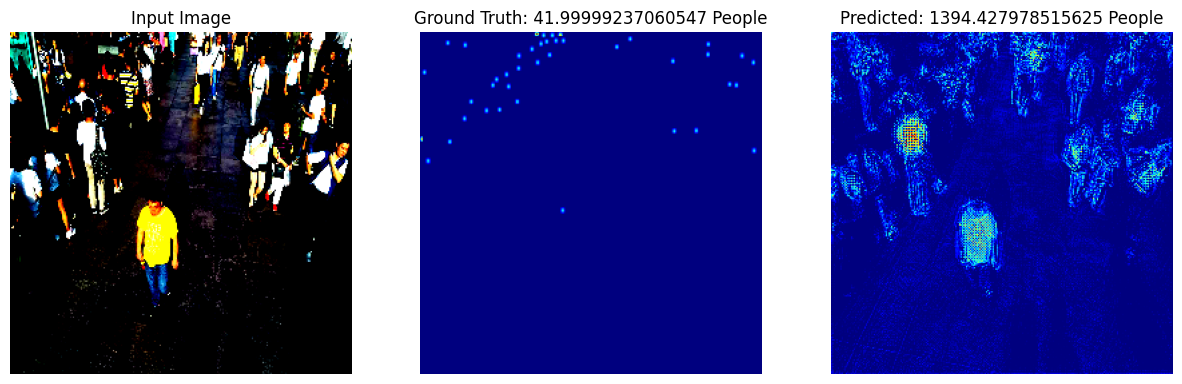

Epoch 2/10, Train Loss: 0.02808183098677546, Validation Loss: 0.0027137788725851834


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.64].


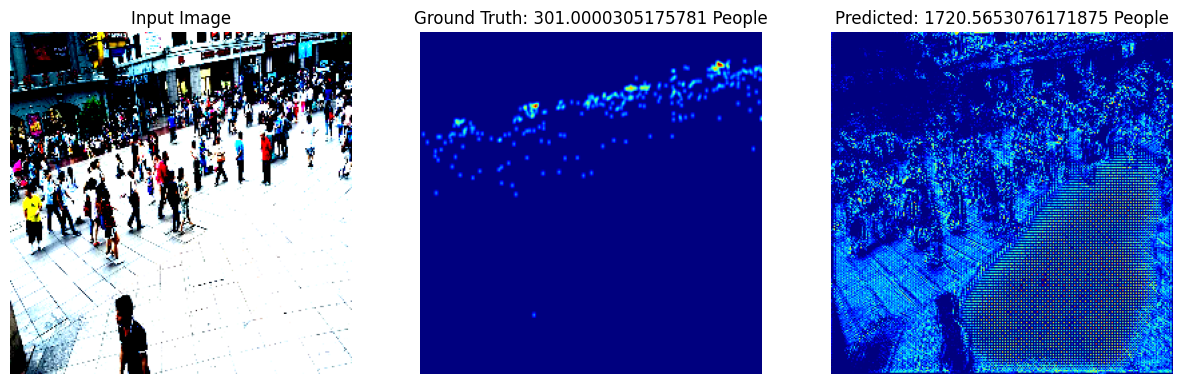

Epoch 3/10, Train Loss: 0.018658481729216872, Validation Loss: 0.0010447206190799044


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.1007793..2.64].


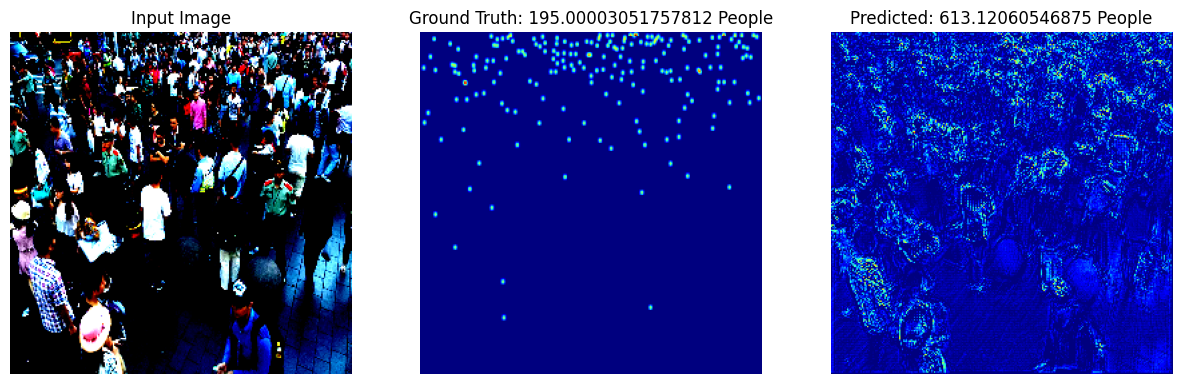

Epoch 4/10, Train Loss: 0.016444266666658224, Validation Loss: 0.0006394127473718475


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.64].


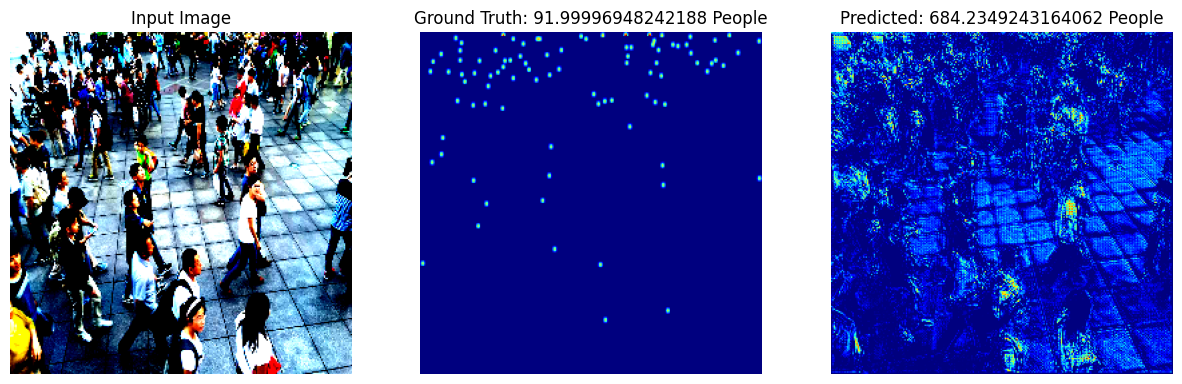

Epoch 5/10, Train Loss: 0.013392045604996383, Validation Loss: 0.0004757349600402426


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.0494049..2.64].


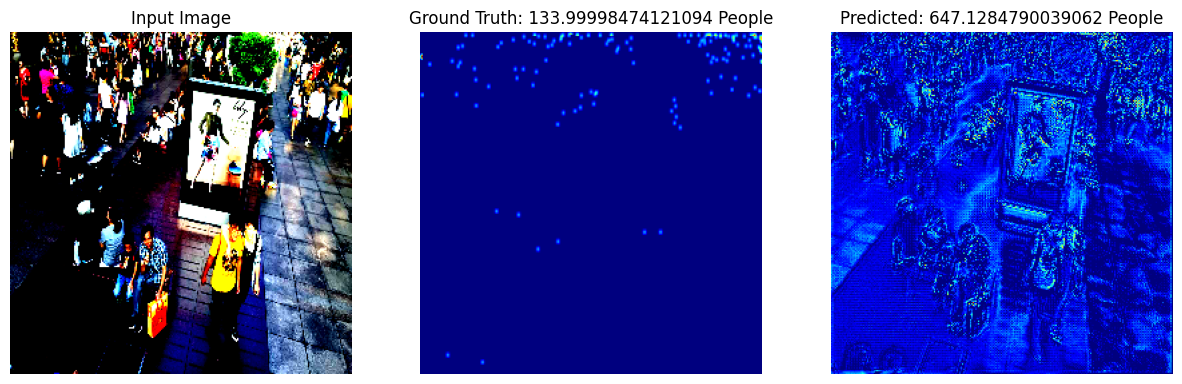

Epoch 6/10, Train Loss: 0.011169072452466934, Validation Loss: 0.0003615892877215755


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.64].


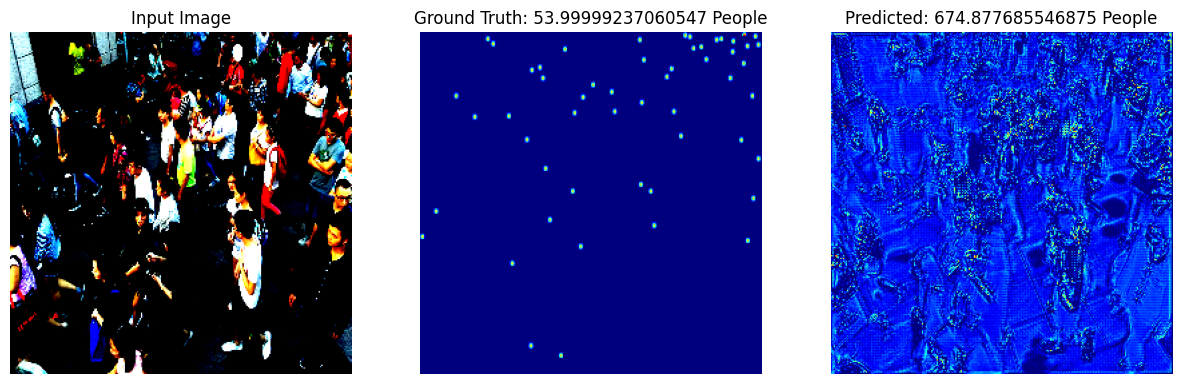

Epoch 7/10, Train Loss: 0.009885794583242387, Validation Loss: 0.00029690199272995935


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.64].


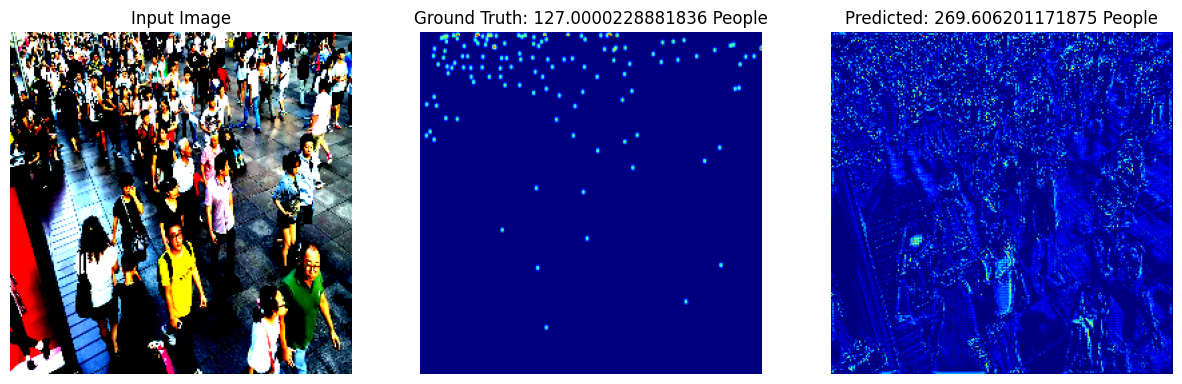

Epoch 8/10, Train Loss: 0.005641749759670347, Validation Loss: 0.00030795423202717654


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.64].


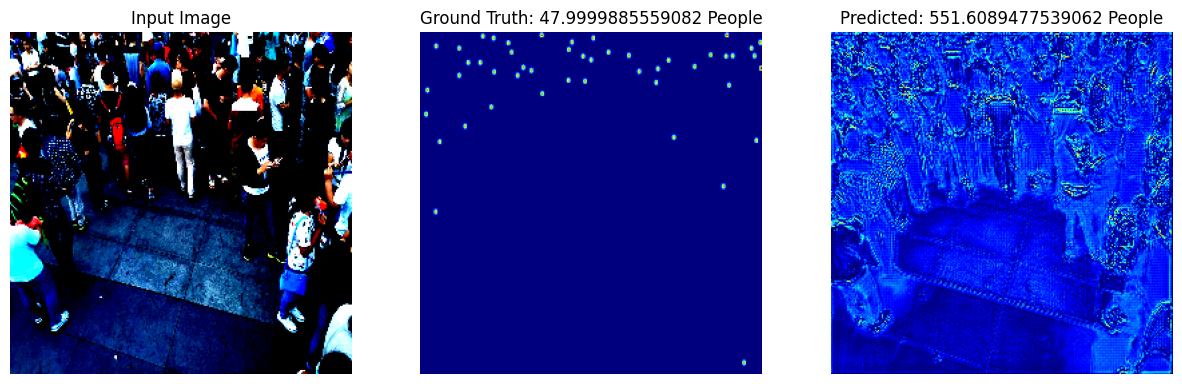

Epoch 9/10, Train Loss: 0.005335901130456478, Validation Loss: 0.00026590565346252127


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.64].


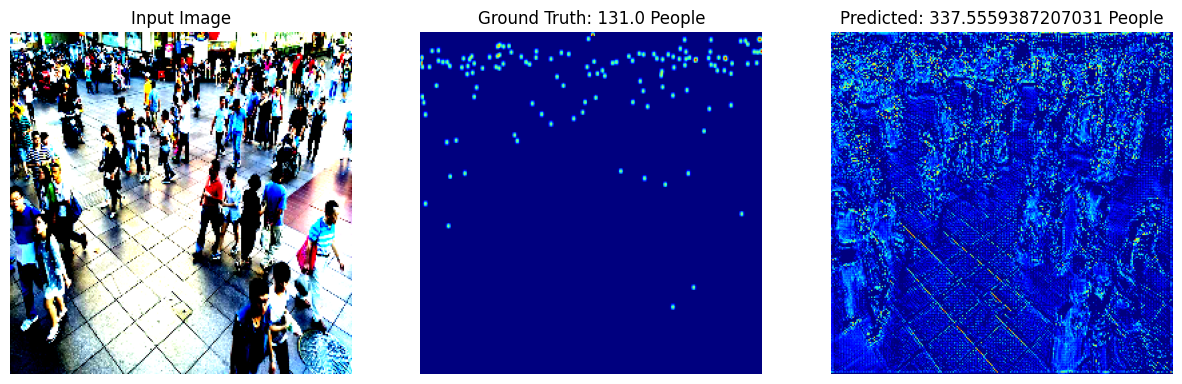

Epoch 10/10, Train Loss: 0.003496882471372373, Validation Loss: 0.00025135039681969566


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.64].


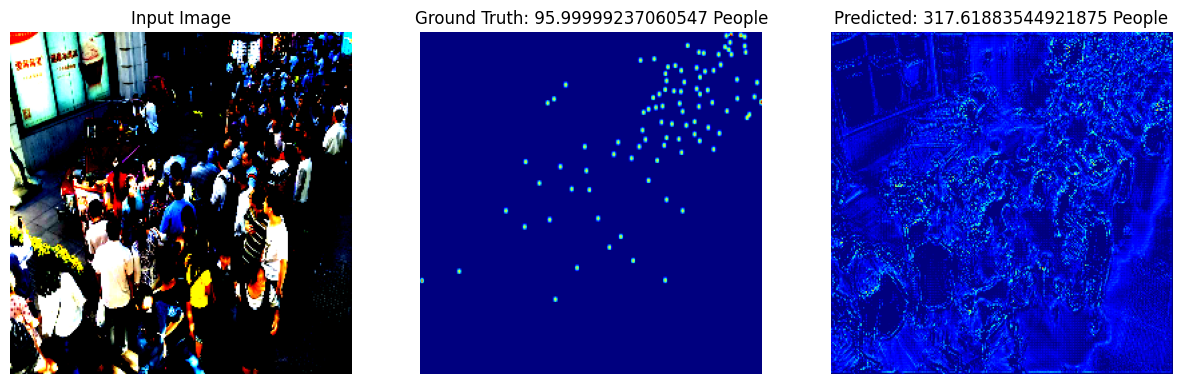

In [52]:
num_epochs = 10
for epoch in range(num_epochs):
    model.train()  
    running_loss = 0.0
    for imgs, gt_maps in train_loader:
        imgs, gt_maps = imgs.to(device), gt_maps.to(device)

        optimizer.zero_grad()
        
        # Forward pass
        outputs = model(imgs)
        # outputs = torch.sigmoid(outputs)  
        # outputs = torch.clamp(outputs, min=0, max=1)
        
        # Compute loss
        loss = criterion(outputs, gt_maps)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    # Validation Loss
    val_loss = evaluate_model(model, val_loader, device)
    
    # Print progress
    print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {running_loss/len(train_loader)}, Validation Loss: {val_loss}")
    
    # Evaluation every epoch
    if (epoch + 1) % 1 == 0:  
        model.eval()
        with torch.no_grad():
            sample_img, sample_gt_map = next(iter(val_loader))
            sample_img, sample_gt_map = sample_img.to(device), sample_gt_map.to(device)

            # Model prediction
            pred_density_map = model(sample_img).cpu().squeeze(1).numpy()  # shape: (B, H, W)

            # Ensure no negative values (optional)
            pred_density_map = np.clip(pred_density_map, 0, None)

            # Ground truth and predicted count
            gt_count = float(sample_gt_map[0].sum().item())  # or sample_gt_map.cpu().numpy()[0].sum()
            pred_count = float(pred_density_map[0].sum())

            # Plot the results
            plot(gt_count, pred_density_map[0], pred_count, sample_img[0].cpu(), sample_gt_map[0].cpu())
